# Finding azimuth angle with noise
# Frequency

In [25]:
import numpy as np # tells python to bring the NumPy library into the current environment
import matplotlib.pyplot as plt # collection of command style functions that make matplotlib work like matlab
import tensorflow as tf # converts regular python code to a callable tensorflow graph function
import random # imports the random module for random number generation
import math # give access to the mathematical functions
import h5py # pythonic interface to the HDF5 binary data format

from tensorflow import keras ## NN library
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv1D # classification example with keras cnn (conv1D)
from tensorflow.keras.layers import MaxPooling1D, Flatten
import os # to interact with the underlying operating system

In [26]:
with h5py.File("Anechoic_Data.h5", "r") as f:
    # List all groups
    items = f.keys()               # Checks what data labels like 'bandwidths' are within the file
    #print("Items in base: ", items)
    G = f.get('generated_data')   # Gets the contents of the generated data folder
    #print(G1.keys())               # Checks what datasets are within the folder
    # time domain dataset within HDF5 file
    dataset = np.array(G.get('dataset')) # Gets the content of the dataset named 'dataset'
    bandwidths = np.array(G.get('bandwidths')) # Gets the content of the bandwidths named 'bandwidths'
    centers = np.array(G.get('centers')) # Gets the content of the center frequency named 'centers'
    print(len(dataset)) # print the length of dataset
    
    for i in range(len(dataset)): # iterate series of values inside the range function
        temp = dataset[i] # temporary dataset
        real_noise = np.random.normal(0,0.1, len(temp)) # real noise
        imag_noise = 1j*np.random.normal(0,0.1, len(temp)) # imaginary noise
        temp = temp + real_noise + imag_noise
        # FFT changes time domain data to frequency domain data
        temp = np.fft.fft(temp) # fourier transform
        #print(np.shape(temp))
        #print(np.real(temp[:8]))
        #temp = np.concatenate(np.real(temp), np.imag(temp))
        #temp = list(np.real(temp)) + list(np.imag(temp))
        #temp = np.array(temp)
        temp = np.abs(temp) # absolute value
        
        dataset[i] = temp # overriding original time domain data with frequecy domain data
        #for n in range(len(temp)):
        #    temp[n] = temp[n] + np.random.normal(0,0.005) + temp[n] + i*np.random.normal(0,0.005)
        #dataset[i] = temp
    
    labels = [] # empty list
    #dataset = dataset[0:10000]
    #print(len(dataset))
    print("Bandwidths: ")
    print(bandwidths[0:10]) # Printing the first 10 bandwidths
    print("Center Frequencies: ")
    print(centers[0:10]) # printing the first 10 center frequencies
    for i in range(len(dataset)):
        params = [bandwidths[i], centers[i]]
        labels.append(params) # append parameter
    print("Appended bandwidths and center frequencies: ")
    print(labels[0:10])
    
# now ready for frequency domain data
allX = dataset # list of 1024-sample or 2048-sample vectors
# ready for bandwidth and center frequency labels
allY = labels # list of labels

#print(allX)

# Split x and y into train and test
trainX = []; testX = [] 
trainY = []; testY = []

# Shuffling indexes for 1024 or 2048 sample vector to avoid biases in NN
N = len(allX)
indexes = list(range(N))
np.random.shuffle(indexes)

M = int(N* 0.2) # 80/20 train/test split

# test dataset
for idx in indexes[0:M] :
    testX.append(allX[idx])
    testY.append(allY[idx])

# train dataset
for idx in indexes[M:] :
    trainX.append(allX[idx])
    trainY.append(allY[idx])


# Converting to numpy arrays of training and testing dataset to be used as input for NN
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)

10000
Bandwidths: 
[0.7757208 0.6309978 0.808145  0.210144  0.2994472 0.3332048 0.501148
 0.4306934 0.7319502 0.590506 ]
Center Frequencies: 
[-0.0012842 -0.0308174  0.021666   0.0039638 -0.022836   0.0207082
  0.0039998  0.0408844 -0.020972   0.0646664]
Appended bandwidths and center frequencies: 
[[0.7757208, -0.0012842], [0.6309978, -0.0308174], [0.808145, 0.021666], [0.210144, 0.0039638], [0.2994472, -0.022836], [0.3332048, 0.0207082], [0.501148, 0.0039998], [0.4306934, 0.0408844], [0.7319502, -0.020972], [0.590506, 0.0646664]]


In [27]:
# Size of signal
sig_size = 1024
# number of elements (elements are in a line can only do azimuth angle)
# element - single metallic (copper) circular antenna within mMIMO array.  It is one of 6x8 elements.
num_of_elements = 2 # number of elements being used in the array
# number of signals
num_of_sigs = 10000 # 1000 can make bigger later
# Random signal
# The 0.5 centers signal amplitude around 0 (random.rand gives value 0-1)
s0t = np.random.rand(sig_size)-0.5 + 1.0j*np.random.rand(sig_size)-0.5j
#print(s0t)

In [28]:
# Stand noise deviation for noise to be added into the signals
noise_sigma = 0.01

## Time shift
## Distance between elements (2 elements)

In [29]:
d = 5e-2 # 5 cm, the distance between one element to the next element within the array
# Azimuth Angle
# make random variable for angle to loop through
# limiting processing of angle range from -60 deg to +60 deg
# array performance is poor at large angles and many phased arrays spec'd for this angle range
az_ang0 = np.deg2rad(-60)  
# Speed of light
c = 299792458 # m/s, speed of light
# formula from plane wave hitting the elements at an angle
delta_t = d*np.sin(az_ang0)/c # time delay 
sample_freq = 100e6 # 100MHz Sampling Frequency
# Doing math in terms of sample index and not in seconds
delta_t_samples = delta_t * sample_freq # number of samples for delta t
print("delta_t_samples = ",delta_t_samples)
print("delta_t = ",delta_t * 1e9,"ns") # nanoseconds
print("distance = ",c*delta_t, "m") # meters


# rename time_samples_from_angle or samples_from_angle
def time_from_angle(az_ang0):
    az_ang0 = np.deg2rad(az_ang0)
    # Time shift
    
    # Distance between elements (2 elements)
    d = 5e-2 # 5 cm
    # Speed of light
    c = 299792458 # m/s
    delta_t = d*np.sin(az_ang0)/c
    sample_freq = 100e6 # 100MHz
    # Doing math in terms of sample index and not in seconds
    delta_t_samples = delta_t * sample_freq
    return delta_t_samples
# time can be a fraction of a sample
print ("Time samples from angle at -60 deg: ")
print(time_from_angle(-60))

delta_t_samples =  -0.014443749011598528
delta_t =  -0.14443749011598528 ns
distance =  -0.04330127018922193 m
Time samples from angle at -60 deg: 
-0.014443749011598528


In [30]:
# Time shift of s0 
#s1 = s0(t-delta_t_samples) 

# FFT
s0f = np.fft.fft(s0t)

# Time shift in Fourier Domain
s1f = s0f*np.exp(-1.0j*(2*np.pi)*delta_t_samples*np.array(range(sig_size))/sig_size)

## Add some noise to the signal

In [31]:
#s0fnoise instead
s0f += (np.random.normal(size = sig_size) + 1.0j*np.random.normal(size = sig_size))*noise_sigma
s1f += (np.random.normal(size = sig_size) + 1.0j*np.random.normal(size = sig_size))*noise_sigma

## This is an example of what we would feed the NN

In [32]:
# Could use a conventional NN (not convolutional) to work better, find example
# Feed network amplitude and phase
s0f_amplitude = np.abs(s0f)
s1f_amplitude = np.abs(s1f)
s0f_phase = np.angle(s0f) ;  s0f_phase = np.unwrap(s0f_phase)
s1f_phase = np.angle(s1f) ;  s1f_phase = np.unwrap(s1f_phase)

## Cells below for testing

slope =  -8.894389103915501e-05


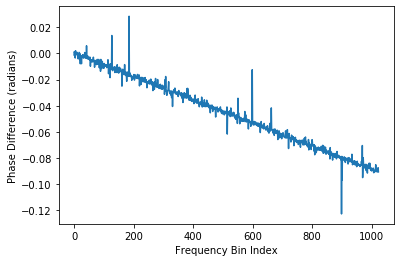

In [33]:
# Testing that shifting is working in frequency domain
# Phase difference
phase_diff = s0f_phase - s1f_phase
#plt.plot(phase_diff)

# Fix phase wrap issue
phase_diff = np.unwrap(phase_diff)
phase_diff = np.unwrap(phase_diff)
plt.plot(phase_diff)
plt.xlabel("Frequency Bin Index")
plt.ylabel("Phase Difference (radians)")

# Slope
slope = np.polyfit(range(sig_size), phase_diff, 1)[0] # square bracket 0 selects slope
print("slope = ", slope)

In [34]:
# Compare slope to time shift
print("delta_t_samples",delta_t_samples)
#print("slope = ",slope)
time_from_slope = slope/(2*np.pi/sig_size)
print("time_from_slope = ",time_from_slope)

delta_t_samples -0.014443749011598528
time_from_slope =  -0.014495600554709458


In [35]:

with h5py.File("Anechoic_Data.h5", "r") as f:
    # List all groups
    items = f.keys()               # Checks what data labels like 'bandwidths' are within the file
    #print("Items in base: ", items)
    G = f.get('generated_data')   #Gets the contents of the generated data within the folder
    #print(G1.keys())               #Checks what datasets are within the folder
    dataset = np.array(G.get('dataset')) #Gets the content of the dataset named 'dataset'
    print(len(dataset))
    print("Randomly Generated Angle, Time sample delay from angle")
    
    #instantiate list, convert list to numpy array (can only append a list, not a numpy array)
    #dataset_list = []
    for i in range(num_of_sigs):
        # Range of random angles from -60 deg to +60 deg
        random_angle = np.random.rand()*60*2 - 60
        delta_t = time_from_angle(random_angle) 
        print("random angle (deg): ", "delta_t (ns): ")
        print(random_angle, delta_t)
        # Transmitted signal, every element will be a time shifted copy of this signal plus a little noise
        # signal s0f is in frequency domain
        s0f = random_sig_generator(sig_size) 
        # loop over number of elements
        # empty vector to label each copy of the signal for each element 
        sigs_from_elements = []
        # this loop uses the time delay for each element and builds signal from shifted copies
        for k in range(num_of_elements):
            s_k = np.copy(s0f)
            # each element's signal copy is time shifted, multiplying by k to increase time shift of each subsequent element
            s_k = time_shift_sig(s_k, delta_t*k)
            s_k = random_noise(s_k, noise_sigma)
            #s_k_amplitude = np.abs(s_k)
            #s_k_phase = np.angle(s_k) ;  s_k_phase = np.unwrap(s_k_phase)
            sigs_from_elements.append(s_k)


        #for m in range(num_of_elements-1):
            # square bracket 1 picks off s_k_phase, this loops goes through all adjacent pairs of elements
            #print(calc_time_from_slope(sigs_from_elements[m], sigs_from_elements[m+1]), end = '  ')


        #print() #

        # might have to massage it but this is close to train NN
        # change to a list and convert to numpy array
        # or do numpy concatenate
        dataset = []
        #np.concatenate()
        dataset.append([random_angle, np.abs(sigs_from_elements), np.unwrap(np.angle(sigs_from_elements))])
        #print("Shape: ", dataset.shape)

10000
Randomly Generated Angle, Time sample delay from angle
random angle (deg):  delta_t (ns): 
-11.10708320177585 -0.0032129440285815817
random angle (deg):  delta_t (ns): 
32.10712264950763 0.00886453061237003
random angle (deg):  delta_t (ns): 
-43.5108820527109 -0.01148281608749892
random angle (deg):  delta_t (ns): 
-57.478517437411554 -0.014062894314731175
random angle (deg):  delta_t (ns): 
49.58282381419065 0.012697850779345156
random angle (deg):  delta_t (ns): 
-44.66465264867052 -0.011724045057938701
random angle (deg):  delta_t (ns): 
-1.813470367445376 -0.000527794205924943
random angle (deg):  delta_t (ns): 
-31.350665796895786 -0.00867724453835091
random angle (deg):  delta_t (ns): 
-13.696945524535607 -0.003949171259844227
random angle (deg):  delta_t (ns): 
-42.72362383000794 -0.011315538623538717
random angle (deg):  delta_t (ns): 
36.2666754179923 0.009865897488973895
random angle (deg):  delta_t (ns): 
-53.58160393153366 -0.013421005169258962
random angle (deg):  d

In [36]:
# Generates a randomized timeshift, outputs that timeshift and the corresponding angle
def timeshift_gen(D):
    """
    D - distance between elements
    """
    #Random angle that the signal is approaching at (-60 to +60)
    angle = np.random.uniform(-1,1)*60
    c = 3e8 # speed of light
    
    #Calculate the time difference between the two antenna elements
    angle_rad = np.radians(angle) # angle in radians
    timeshift = (np.sin(angle_rad)*D)/c # sin(angle in radians) * distance between elements / speed of light)
    
    return timeshift, angle

In [37]:
#Apply the timeshift to the signal
def apply_shift(signal, timeshift, fc, fs):
    # delta(t0) -> exp(-2j*omega*t0)
    # delta(t1) -> exp(-2j*omega*t1)

    n = len(signal)
    assert n%2 == 0 # n modulus 2 
    # signal in frequency domain
    signal_1_f = np.fft.fft(signal) # fourier transform
    signal_1_f = np.fft.fftshift(signal_1_f) # shift signal
    
    signal_1_f_0 = signal_1_f[0]
    
    freqs = np.array(range(-n//2, n//2))/n * fs # // integer division 
    freqs = freqs + fc
    
    # This complex multiplication does the timeshift (e^-jwt for the phase)
    signal_1_f = signal_1_f*np.exp(-1j*2*np.pi*freqs*timeshift) # s1f = s1f*e^(-jwt)
    # Using cosine factor for angle of arrival with impressed timeshift
    signal_1_f[0] = signal_1_f_0 * np.cos(2*np.pi*fs/2*timeshift) * np.exp(-1j*2*np.pi*fc*timeshift)
    
    signal_1_f = np.fft.fftshift(signal_1_f)
    # inverse fourier transform to convert to time domain
    signal_1_t = np.fft.ifft(signal_1_f)
    #print(signal_1_f)
    
    return signal_1_t

In [38]:
with h5py.File("2048_Angles_First.h5", "r") as f:
    # List all groups
    items = f.keys()               #Checks what "folders" are within the file
    #print("Items in base: ", items)
    G1 = f.get('generated_data')   #Gets the contents of the generated data folder
    #print(G1.keys())               #Checks what datasets are within the folder
    
    #Gets the content of the dataset named 'signal_0' (Stored signals are in the time domain)
    #The rest of these lines also just read the data from the h5 file
    signal_0 = np.array(G1.get('signal_0')); #signal_0 = signal_0[0:7500] 
    #signal_1 = np.array(G1.get('signal_1')); #signal_1 = signal_1[0:7500]

    center = np.array(G1.get('centers'))
    bandwidth = np.array(G1.get('bandwidths'))
    #angles = np.array(G1.get('angles')); #angles = angles[0:7500]
    print(len(signal_0))

30000


In [39]:
signal_1 = []
angles = []
D = 0.05 # 5cm between elements
fc = 2e9 # 2 GHz center frequency
fs = 5e6 # 5 MHz sampling frequency
for i in range(len(signal_0)):
    timeshift, temp_angle = timeshift_gen(D)
    signal_1_t = apply_shift(signal_0[i], timeshift, fc, fs)
    signal_1.append(signal_1_t)
    angles.append(temp_angle)
    
signal_1 = np.array(signal_1)
angles = np.array(angles)

In [40]:
#This function takes the two signals and applies noise
# normal implies gaussian distribution
def add_noise(signal, noise):
    real_noise_0 = np.random.normal(0,noise, len(signal)) # real noise
    imag_noise_0 = 1j*np.random.normal(0,noise, len(signal)) # imaginary noise
    signal_noise = signal + real_noise_0 + imag_noise_0 # total signal noise

    return signal_noise

In [41]:
#noise = 0.05
# flat distribution
for i in range(len(signal_0)):
    noise = np.random.uniform(0,0.0)
    signal_0[i] = add_noise(signal_0[i], noise)
    signal_1[i] = add_noise(signal_1[i], noise)

Freqs =  1997500000.0
Slope:  1.1061672116341767e-10
Calculated Angle:  41.582695113850484
Angle:  41.657281666465074


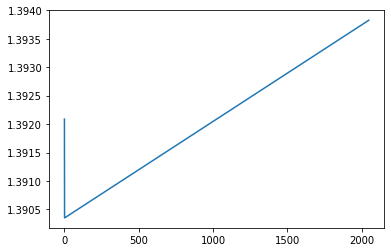

In [42]:
# Verify angles
signal_0_f = np.fft.fft(signal_0[1]); signal_0_f = np.fft.fftshift(signal_0_f)
signal_1_f = np.fft.fft(signal_1[1]); signal_1_f = np.fft.fftshift(signal_1_f)

phase0 = np.angle(signal_0_f)
phase1 = np.angle(signal_1_f)

# unwrap graph where plot is shifted up on vertical axis by increments of 2pi
phasediff = np.unwrap(phase0-phase1)
plt.plot(phasediff)

n = len(signal_0_f)
c = 3e8 # speed of light
# fs = 100 MHz sampling frequency
freqs = np.array(range(-n//2, n//2))/n * fs
freqs = freqs + fc
print("Freqs = ", freqs[0])

# 1 is the order of the polynomial
# [0] picks off first polynomial coefficient which is the slope
slope = np.polyfit(freqs, phasediff, 1)[0]/(2*np.pi)
print("Slope: ", slope)

# Taking arcsin to find calculated angle as a function of slope (which is a measure of the timeshift)
calc_angle = math.asin((c*slope)/D)
#calc_angle = math.sin((c*slope*D))
calc_angle = calc_angle * 180/np.pi #Converts to degrees

print("Calculated Angle: ", calc_angle)
print("Angle: ", angles[1])

## Frequency 

10000


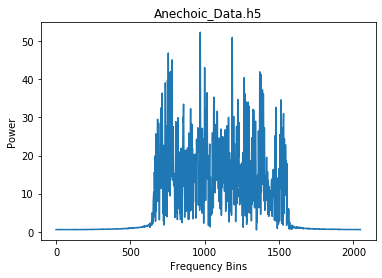

In [43]:
# Bandwidth (bw)
# Center Frequency (c_freq)
# Anechoic Data HDF5 File Labels
with h5py.File("Anechoic_Data.h5", "r") as f:
    # List all groups
    items = f.keys()               # Checks what "folders" are within the file
    #print("Items in base: ", items)
    G = f.get('generated_data')   # Gets the contents of the generated data folder
    #print(G1.keys())               #Checks what datasets are within the folder
    dataset = np.array(G.get('dataset')) # Gets the content of the dataset named 'dataset'
    print(len(dataset))
    bw = np.array(G.get('bandwidths')) # Gets the content of the bandwidths named 'bandwidths'
    c_freq = np.array(G.get('centers')) # Gets the content of the center frequency named 'centers'
    
    # FFT to find bw
    sig_data = G.get('dataset')
    sig_gen = np.array(sig_data)
    dataset_fft = abs(np.fft.fftshift(np.fft.fft(sig_gen), (1,)))
    plt.plot(abs(dataset_fft[7]))
    plt.xlabel("Frequency Bins")
    plt.ylabel("Power")
    plt.title("Anechoic_Data.h5")
    plt.show()
    
    # c_freq
    

In [44]:
# Function that generates random element signals 
def random_sig_generator (sig_size):
    n = sig_size
    # New signal in time domain
    s0t = np.random.rand(n)-0.5 + 1.0j*np.random.rand(n)-0.5j
    # fourier
    s0f = np.fft.fft(s0t)
    return s0f
      
def time_shift_sig (s0f, delta_t_samples):
    n = len(s0f)
    # Time shift in Fourier Domain
    # Fourier transform of Dirac Delta function
    # e^(-j w delta_t)
    # w = FFT shift(carrier freq - bandwidth/2 to carrier freq + bandwidth/2)
    fc = 3.6e9 # 3.6 GHz Center Frequency
    fs = 5e6 # 5 MHz Sampling Frequency
    w = np.linspace(fc-fs/2, fc+fs/2, n, endpoint = False)
    w = np.fft.fftshift(w)
    s1f = s0f*np.exp(-1.0j*(2*np.pi)*delta_t_samples*w/fs) # add to whatever the carrier frequency is (3.6 GHz)
    return s1f
    
# function to add random noise
def random_noise(s0f, noise_sigma):
    n = len(s0f)
    s0f += (np.random.normal(size = n) + 1.0j*np.random.normal(size = n))*noise_sigma
    return s0f

# Feed network amplitude and phase
def calc_time_from_slope(s0f, s1f):
    s0f_amplitude = np.abs(s0f)
    s1f_amplitude = np.abs(s1f)
    s0f_phase = np.angle(s0f) ;  s0f_phase = np.unwrap(s0f_phase)
    s1f_phase = np.angle(s1f) ;  s1f_phase = np.unwrap(s1f_phase)
    
    # Testing that shifting is working in frequency domain
    # Phase difference
    phase_diff = s0f_phase - s1f_phase
    #plt.plot(phase_diff)

    # Fix phase wrap issue
    # unwrap graph where plot is shifted up on vertical axis by increments of 2pi
    phase_diff = np.unwrap(phase_diff)
    phase_diff = np.unwrap(phase_diff)

    # Slope
    slope = np.polyfit(range(sig_size), phase_diff, 1)[0] # square bracket 0 selects slope
    #print("slope = ", slope)
    
    time_from_slope = slope/(2*np.pi/sig_size)
    return time_from_slope

In [45]:
# Function that generates random element signals 
def random_sig_generator (sig_size):
    n = sig_size
    # New signal in time domain
    s0t = np.random.rand(n)-0.5 + 1.0j*np.random.rand(n)-0.5j
    # fourier
    s0f = np.fft.fft(s0t)
    return s0f
      
def time_shift_sig (s0f, delta_t_samples):
    n = len(s0f)
    # Time shift in Fourier Domain
    # Fourier transform of Dirac Delta function
    # e^(-j w delta_t)
    # w = FFT shift(carrier freq - bandwidth/2 to carrier freq + bandwidth/2)
    fc = 3.6e9
    fs = 5e6
    w = np.linspace(fc-fs/2, fc+fs/2, n, endpoint = False)
    w = np.fft.fftshift(w)
    s1f = s0f*np.exp(-1.0j*(2*np.pi)*delta_t_samples*w/fs) # add to whatever the carrier frequency is (3.6 GHz)
    return s1f
    
# function to add random noise
def random_noise(s0f, noise_sigma):
    n = len(s0f)
    s0f += (np.random.normal(size = n) + 1.0j*np.random.normal(size = n))*noise_sigma
    return s0f

def calc_time_from_slope(s0f, s1f):
    s0f_amplitude = np.abs(s0f)
    s1f_amplitude = np.abs(s1f)
    s0f_phase = np.angle(s0f) ;  s0f_phase = np.unwrap(s0f_phase)
    s1f_phase = np.angle(s1f) ;  s1f_phase = np.unwrap(s1f_phase)
    
    # Testing that shifting is working in frequency domain
    # Phase difference
    phase_diff = s0f_phase - s1f_phase
    #plt.plot(phase_diff)

    # Fix phase wrap issue
    phase_diff = np.unwrap(phase_diff)
    phase_diff = np.unwrap(phase_diff)

    # Slope
    slope = np.polyfit(range(sig_size), phase_diff, 1)[0] # square bracket 0 selects slope
    #print("slope = ", slope)
    
    time_from_slope = slope/(2*np.pi/sig_size)
    return time_from_slope

In [46]:
# Generates a randomized timeshift, outputs that timeshift and the corresponding angle
def timeshift_gen(D):
    
    # D - distance between elements
    #Random angle that the signal is approaching (-60 to 60)
    angle = np.random.uniform(-1,1)*60
    # print angle
    # angle = 45
    c = 3e8 # m/s speed of light
    
    # Calculate the time difference between two antenna elements
    angle_rad = np.radians(angle)
    timeshift = (np.sin(angle_rad)*D)/c
    return timeshift, angle